# Problem Statement : 



### Explore and identify different segments present in the customer transaction data

# DataSet
The dataset contains transactions on an e-commerce website between the period Feb 2018 to Feb 2019 from customers across different countries. 

File: transaction_data.csv
Columns

UserId 				- Unique identifier of a user.

TransactionId 			- Unique identifier of a transaction. If the same TransactionId is present in multiple rows, then all those products are bought together in the same transaction.

TransactionTime		- Time at which the transaction is performed

ItemCode			- Unique identifier of the product purchased

ItemDescription		- Simple description of the product purchased

NumberOfItemsPurchased	- Quantity of the product purchased in the transaction

CostPerItem			- Price per each unit of the product

Country			- Country from which the purchase is made


# Approch-
## # Customer Segmentation
Here the E-commerce dataset of user purchases is given so I am trying develop a model that allow me to do two things:

1. Classifying customers into segments.
2. Anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase by assigning them appropriate cluster/segment

## Import all important Libraries 

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import warnings 
%matplotlib inline

C:\Users\rkkir\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
transaction_data=pd.read_csv("transaction_data.csv")

In [3]:
transaction_data.sort_values(ascending=False,by="TransactionTime")

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
374245,372750,6162508,Wed Sep 26 13:29:00 IST 2018,464415,METAL SIGN EMPIRE TEA,36,1.10,United Kingdom
384277,372750,6162508,Wed Sep 26 13:29:00 IST 2018,357441,NAMASTE SWAGAT INCENSE,18,0.42,United Kingdom
513245,372750,6162508,Wed Sep 26 13:29:00 IST 2018,357252,ORIGAMI JASMINE INCENSE/CANDLE SET,30,1.18,United Kingdom
861415,372750,6162508,Wed Sep 26 13:29:00 IST 2018,357252,ORIGAMI ROSE INCENSE/CANDLE SET,30,1.18,United Kingdom
413483,372750,6162508,Wed Sep 26 13:29:00 IST 2018,357252,ORIGAMI SANDLEWOOD INCENSE/CAND SET,30,1.18,United Kingdom
...,...,...,...,...,...,...,...,...
881206,362103,5960185,Fri Apr 06 06:15:00 IST 2018,1732374,WOODEN FRAME ANTIQUE WHITE,18,4.08,United Kingdom
402947,362103,5960185,Fri Apr 06 06:15:00 IST 2018,451185,RETROSPOT HEART HOT WATER BOTTLE,30,6.84,United Kingdom
343588,362103,5960185,Fri Apr 06 06:15:00 IST 2018,1528779,PINK PILLAR CANDLE SILVER FLOCK,3,4.08,United Kingdom
184217,362103,5960185,Fri Apr 06 06:15:00 IST 2018,1528779,IVORY PILLAR CANDLE SILVER FLOCK,12,4.08,United Kingdom


In [4]:
print("transaction_data dimensions",transaction_data.shape)

transaction_data dimensions (1083818, 8)


In [5]:
pd.to_datetime(transaction_data["TransactionTime"]).describe()

C:\Users\rkkir\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


count                 1083818
unique                  23260
top       2019-01-12 10:41:00
freq                     2228
first     2018-02-12 04:26:00
last      2028-02-18 14:36:00
Name: TransactionTime, dtype: object

#  Exploratory Data Analysis 

## Identify null values

In [6]:
# gives some infomation on columns types and number of null values
trs_info=pd.DataFrame(transaction_data.dtypes).T.rename(index={0:'column type'})
trs_info=trs_info.append(pd.DataFrame(transaction_data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
trs_info=trs_info.append(pd.DataFrame(transaction_data.isnull().sum()/transaction_data.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(trs_info)


---------- Display information about column types and number of null values ----------


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
column type,int64,int64,object,int64,object,int64,float64,object
null values (nb),0,0,0,0,2908,0,0,0
null values (%),0,0,0,0,0.268311,0,0,0


here ItemDescription has 2908 (0.26%) null values so droping this null values

In [7]:
transaction_data.dropna(axis = 0, subset = ['ItemDescription'], inplace = True)

In [8]:
# gives some infomation on columns types and number of null values
trs_info=pd.DataFrame(transaction_data.dtypes).T.rename(index={0:'column type'})
trs_info=trs_info.append(pd.DataFrame(transaction_data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
trs_info=trs_info.append(pd.DataFrame(transaction_data.isnull().sum()/transaction_data.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(trs_info)

---------- Display information about column types and number of null values ----------


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
column type,int64,int64,object,int64,object,int64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [9]:
transaction_data.shape

(1080910, 8)

In [10]:
print('Duplicate data entries: {}'.format(transaction_data.duplicated().sum()))
transaction_data.drop_duplicates(inplace = True)

Duplicate data entries: 545792


In [11]:
print('Duplicate data entries: {}'.format(transaction_data.duplicated().sum()))

Duplicate data entries: 0


### Exploring data attributes

Exploring the data attribute : Country 

In [12]:
print("'No. of cuntries in dataframe:",len(transaction_data.Country.value_counts()))

'No. of cuntries in dataframe: 38


In [13]:
temp_no_of_order_per_count = transaction_data[['UserId','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10)
print
print (temp_no_of_order_per_count.sort_values(
    by='UserId', ascending=False).rename(index=str,
                                        columns={"UserId": "Country wise number of order"}))

---------- Contry-wise order calculation ----------
                 Country  Country wise number of order
36        United Kingdom                        488779
14               Germany                          9480
13                France                          8541
10                  EIRE                          8184
31                 Spain                          2528
24           Netherlands                          2371
3                Belgium                          2069
33           Switzerland                          1994
27              Portugal                          1510
0              Australia                          1258
25                Norway                          1086
19                 Italy                           803
6        Channel Islands                           757
12               Finland                           695
7                 Cyprus                           610
32                Sweden                           461
37           

#### ** Exploring the data attribute : Customers and products **

In [14]:
transaction_data.head(5)

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [15]:
pd.DataFrame([{'products': len(transaction_data['ItemCode'].value_counts()),    
               'transactions': len(transaction_data['TransactionId'].value_counts()),
               'customers': len(transaction_data['UserId'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

,products,transactions,customers
quantity,3321,24446,4373


As you can see that this dataset contain the recods of 4373 users who bought 3321 different items. There are 24446 transactions which are carried out.

Now we need to explore the number of products purchased in every transaction

In [16]:
temp = transaction_data.groupby(by=['UserId', 'TransactionId'], as_index=False)['TransactionTime'].count()
nb_products_per_basket = temp.rename(columns = {'TransactionTime':'Number of products'})
nb_products_per_basket.sort_values('UserId')

,UserId,TransactionId,Number of products
0,-1,5901984,526
1513,-1,6232622,199
1512,-1,6232369,1
1511,-1,6232358,1
1510,-1,6232347,95
...,...,...,...
24433,383943,6137516,76
24442,383943,6389592,50
24444,384027,6277865,38
24443,384027,6094715,29


Points to be noted here:

There are some users who bought only comes 3 time on the E-commerce platform and purchased one
item. The example of this kind of user is UserId 384027.

There are some users who frequently buy large number of items per order. The example of this kind of user is UserId -1.

In [17]:
display(transaction_data.sort_values('UserId')[:5])

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
1081501,-1,6091437,Tue Jul 31 06:46:00 IST 2018,470631,JUMBO SHOPPER VINTAGE RED PAISLEY,15,5.70,United Kingdom
412676,-1,6109367,Tue Aug 14 13:26:00 IST 2018,444486,COOK WITH WINE METAL SIGN,3,5.70,United Kingdom
412673,-1,6168492,Mon Oct 01 12:12:00 IST 2018,461832,VINTAGE PAISLEY STATIONERY SET,21,3.40,United Kingdom
412671,-1,6067017,Sun Jul 15 05:44:00 IST 2018,446040,BLUE POLKADOT CUP,3,2.25,United Kingdom
412662,-1,6390813,Sun Feb 17 12:26:00 IST 2019,490455,HOT WATER BOTTLE KEEP CALM,6,14.90,United Kingdom


## Spending Analysis of customer

In [18]:
transaction_data['TotalPrice'] = transaction_data['CostPerItem'] * (transaction_data['NumberOfItemsPurchased'])
transaction_data.sort_values('UserId')[:5]

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,TotalPrice
1081501,-1,6091437,Tue Jul 31 06:46:00 IST 2018,470631,JUMBO SHOPPER VINTAGE RED PAISLEY,15,5.70,United Kingdom,85.50
412676,-1,6109367,Tue Aug 14 13:26:00 IST 2018,444486,COOK WITH WINE METAL SIGN,3,5.70,United Kingdom,17.10
412673,-1,6168492,Mon Oct 01 12:12:00 IST 2018,461832,VINTAGE PAISLEY STATIONERY SET,21,3.40,United Kingdom,71.40
412671,-1,6067017,Sun Jul 15 05:44:00 IST 2018,446040,BLUE POLKADOT CUP,3,2.25,United Kingdom,6.75
412662,-1,6390813,Sun Feb 17 12:26:00 IST 2019,490455,HOT WATER BOTTLE KEEP CALM,6,14.90,United Kingdom,89.40


Each entry of the dataframe indicates prices for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order price:

In [19]:
# sum of purchases / user & order
temp = transaction_data.groupby(by=['UserId', 'TransactionId'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
transaction_data['InvoiceDate_int'] = pd.to_datetime(transaction_data['TransactionTime']).astype('int64')
temp = transaction_data.groupby(by=['UserId', 'TransactionId'], as_index=False)['InvoiceDate_int'].mean()
transaction_data.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'TransactionTime'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('UserId')[:6]

C:\Users\rkkir\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,UserId,TransactionId,Basket Price,TransactionTime
0,-1,5901984,22865.88,2018-02-12 10:32:00.000003840
1287,-1,6166237,13853.58,2018-09-30 09:57:00.000001536
1285,-1,6165434,84.96,2018-09-30 06:51:00.000000000
1284,-1,6164829,2920.59,2018-09-29 12:08:00.000000000
1283,-1,6164818,1220.97,2018-09-29 12:06:00.000000000
1282,-1,6164774,12241.50,2018-09-29 11:56:00.000001536


In order to have a global view of the type of order performed in this dataset, I determine how the purchases are divided according to total prices:

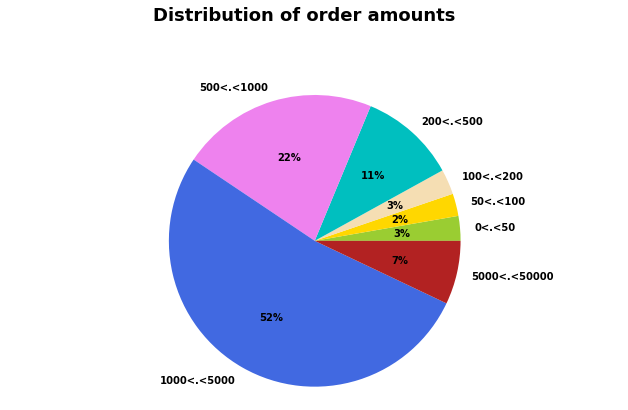

In [20]:
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

### It can be seen that the vast majority of orders concern relatively large purchases given that 74 % of purchases give prices in excess of  1000.

## Analysis of the product categories
In the data-frame, products are uniquely identified through the StockCode variable. A short description of the products is given in the Description variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

### Products Description
As a first step, I extract from the Description variable the information that will prove useful. To do this, I use the following function:

In [21]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("number of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

>extract the names (proper, common) appearing in the products description

>for each name, I extract the root of the word and aggregate the set of names associated with this particular root 

>count the number of times each root appears in the dataframe when several words are listed for the same root,

>I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

>The first step of the analysis is to retrieve the list of products:

In [22]:
df_products = pd.DataFrame(transaction_data['ItemDescription'].unique()).rename(columns = {0:'Description'})

In [23]:
df_products

,Description
0,FAMILY ALBUM WHITE PICTURE FRAME
1,LONDON BUS COFFEE MUG
2,SET 12 COLOUR PENCILS DOLLY GIRL
3,UNION JACK FLAG LUGGAGE TAG
4,WASHROOM METAL SIGN
...,...
4218,rusty thrown away
4219,SET/5 RED SPOTTY LID GLASS BOWLS
4220,mouldy
4221,4 GOLD FLOCK CHRISTMAS BALLS


Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [24]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

number of keywords in variable 'Description': 1602


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurrence:

In [25]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

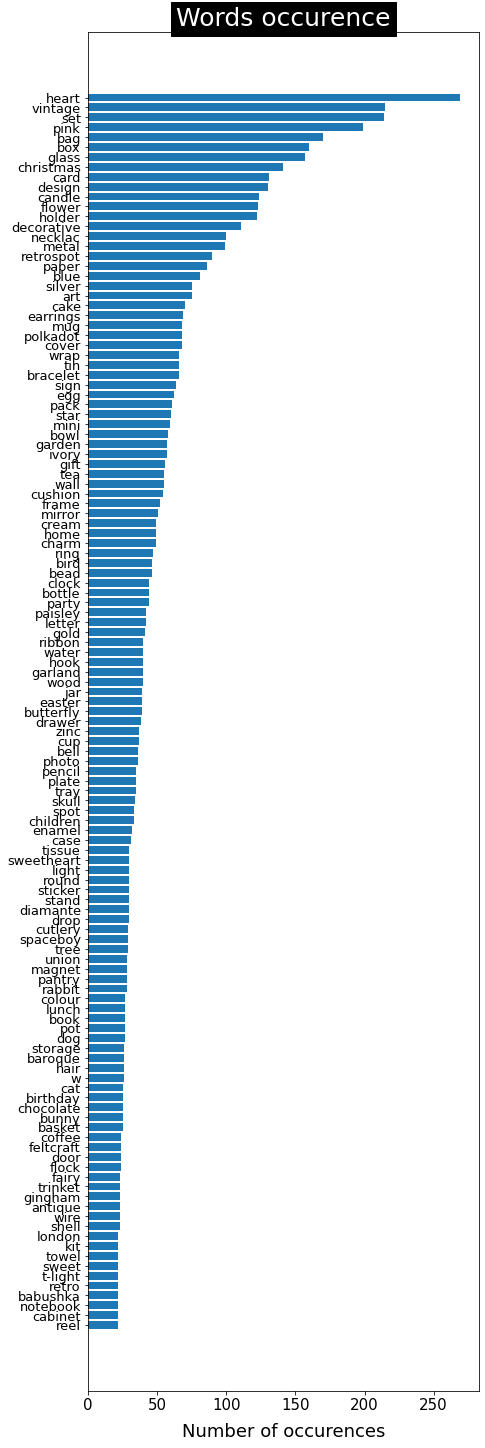

In [26]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

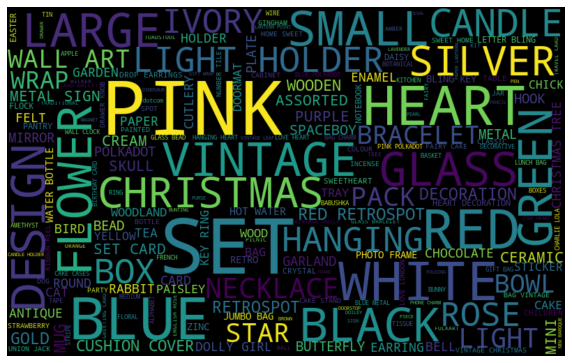

In [27]:
all_words = ' '.join([text for text in df_products['Description']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Defining product categories 

The list that was obtained contains more than 1600 keywords and the most frequent ones appear in more than 200 products. However, while examining the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [28]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
 
list_products.sort(key = lambda x:x[1], reverse = True)
print('Preserved words:', len(list_products))

Preserved words: 197


#### Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | word  1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [29]:
liste_produits = transaction_data['ItemDescription'].unique()
print(liste_produits[0:2])
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
print(X[0:1])

['FAMILY ALBUM WHITE PICTURE FRAME' 'LONDON BUS COFFEE MUG']
   heart  vintage  set  bag  box  glass  christmas  card  design  candle  ...  \
0      0        0    0    0    0      0          0     0       0       0  ...   

   house  milk  funky  diner  square  tidy  point  jewel  clip  plant  
0      0     0      0      0       0     0      0      0     0      0  

[1 rows x 197 columns]


* The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. 



* In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [30]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    #print(i)
    #print(col)
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = transaction_data[ transaction_data['ItemDescription'] == prod]['CostPerItem'].mean()
    #print (prix)
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [31]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       464                 
1<.<2       672                 
2<.<3       738                 
3<.<5       842                 
5<.<10      820                 
.>10        687                 


#### Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the [kmodes](https://pypi.python.org/pypi/kmodes/) package which is not available on the current plateform. Hence, I use the **kmeans** method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [32]:
matrix = X
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.09703435002030578
For n_clusters = 4 The average silhouette_score is : 0.09502224004192757
For n_clusters = 5 The average silhouette_score is : 0.13286208648329914
For n_clusters = 6 The average silhouette_score is : 0.13261267128461734
For n_clusters = 7 The average silhouette_score is : 0.1447800573666218
For n_clusters = 8 The average silhouette_score is : 0.15009836459630205
For n_clusters = 9 The average silhouette_score is : 0.14469840738807907


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

#### Characterizing the content of clusters

I check the number of elements in every class:

In [33]:
pd.Series(clusters).value_counts()

4    743
1    725
6    656
0    579
7    554
5    440
2    285
8    128
3    113
dtype: int64

a: _Silhouette intra-cluster score_ **

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [34]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        #color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,       
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

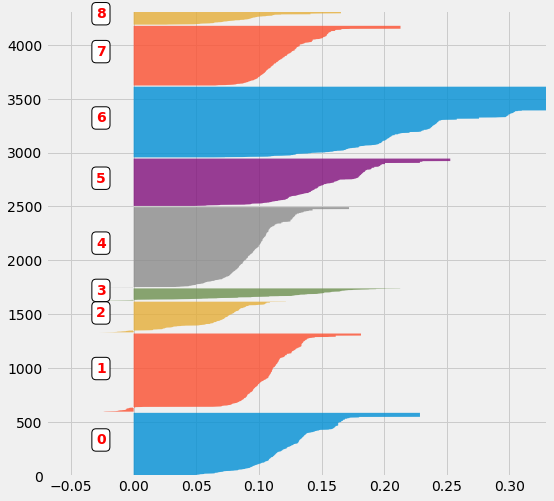

In [35]:

# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

## b: _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [36]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

and I output the result as wordclouds:

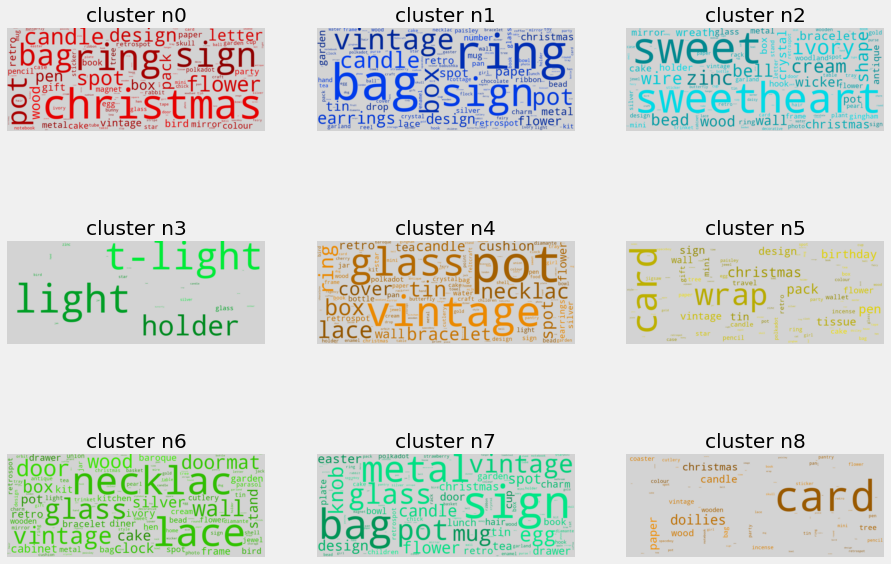

In [37]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,3,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

** c: _Principal Component Analysis_ **

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [38]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

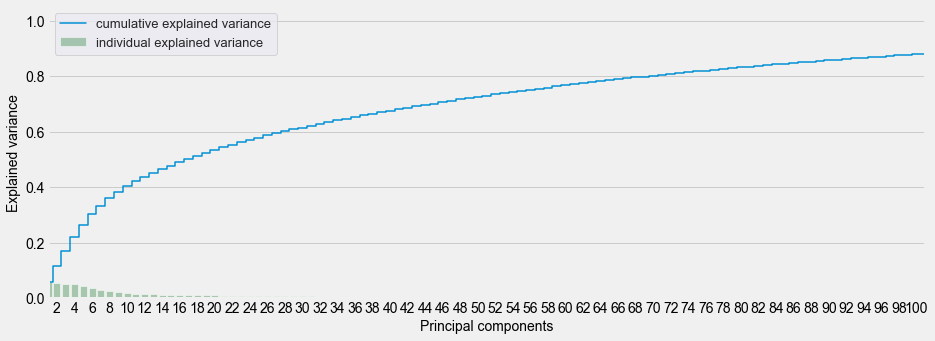

In [39]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:


## Customer categories

Steps for generatin

* Formatting data 
  * Grouping products  
  * Splitting of the dataset 
  * Grouping orders  
* Creating customer categories 
  * Data encoding 
  * Creating categories 



### Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable **categ_product** where I indicate the cluster of each product :

In [40]:
transaction_data

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,TotalPrice
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,70.38
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,10.56
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,64.80
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,5.19
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom,10.20
...,...,...,...,...,...,...,...,...,...
1080730,-1,6345240,Mon Jan 28 11:23:00 IST 2019,487116,VINTAGE LEAF MAGNETIC NOTEPAD,3,4.55,United Kingdom,13.65
1081224,342636,6268328,Tue Dec 18 09:48:00 IST 2018,481761,CHRISTMAS LIGHTS 10 REINDEER,24,11.73,United Kingdom,281.52
1081271,374577,6277348,Sun Dec 23 10:34:00 IST 2018,478506,CUSHION COVER PINK UNION JACK,9,8.22,United Kingdom,73.98
1081376,378861,5973099,Mon Apr 16 09:11:00 IST 2018,469707,CHILDRENS APRON SPACEBOY DESIGN,12,2.70,United Kingdom,32.40


In [41]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

transaction_data['categ_product'] = transaction_data.loc[:, 'ItemDescription'].map(corresp)
transaction_data[['TransactionId', 'ItemDescription', 
            'categ_product']][:10]

,TransactionId,ItemDescription,categ_product
0,6355745,FAMILY ALBUM WHITE PICTURE FRAME,6
1,6283376,LONDON BUS COFFEE MUG,1
2,6385599,SET 12 COLOUR PENCILS DOLLY GIRL,0
3,6044973,UNION JACK FLAG LUGGAGE TAG,7
4,6143225,WASHROOM METAL SIGN,7
5,6307136,CUT GLASS T-LIGHT HOLDER OCTAGON,3
6,6162981,NATURAL SLATE CHALKBOARD LARGE,4
7,6143225,SKULLS WRITING SET,8
8,6255403,MULTI COLOUR SILVER T-LIGHT HOLDER,3
9,6387425,SET OF 6 RIBBONS PERFECTLY PRETTY,1


#### Grouping products

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [42]:
transaction_data

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,TotalPrice,categ_product
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,70.38,6
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,10.56,1
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,64.80,0
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,5.19,7
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom,10.20,7
...,...,...,...,...,...,...,...,...,...,...
1080730,-1,6345240,Mon Jan 28 11:23:00 IST 2019,487116,VINTAGE LEAF MAGNETIC NOTEPAD,3,4.55,United Kingdom,13.65,7
1081224,342636,6268328,Tue Dec 18 09:48:00 IST 2018,481761,CHRISTMAS LIGHTS 10 REINDEER,24,11.73,United Kingdom,281.52,6
1081271,374577,6277348,Sun Dec 23 10:34:00 IST 2018,478506,CUSHION COVER PINK UNION JACK,9,8.22,United Kingdom,73.98,6
1081376,378861,5973099,Mon Apr 16 09:11:00 IST 2018,469707,CHILDRENS APRON SPACEBOY DESIGN,12,2.70,United Kingdom,32.40,1


In [43]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = transaction_data[transaction_data['categ_product'] == i]
    price_temp = df_temp['CostPerItem'] * (df_temp['NumberOfItemsPurchased'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    transaction_data.loc[:, col] = price_temp
    transaction_data[col].fillna(0, inplace = True)


transaction_data[['TransactionId', 'ItemDescription', 
            'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:10]

,TransactionId,ItemDescription,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,6355745,FAMILY ALBUM WHITE PICTURE FRAME,6,0.0,0.00,0.0,0.00,0.00
1,6283376,LONDON BUS COFFEE MUG,1,0.0,10.56,0.0,0.00,0.00
2,6385599,SET 12 COLOUR PENCILS DOLLY GIRL,0,64.8,0.00,0.0,0.00,0.00
3,6044973,UNION JACK FLAG LUGGAGE TAG,7,0.0,0.00,0.0,0.00,0.00
4,6143225,WASHROOM METAL SIGN,7,0.0,0.00,0.0,0.00,0.00
5,6307136,CUT GLASS T-LIGHT HOLDER OCTAGON,3,0.0,0.00,0.0,42.24,0.00
6,6162981,NATURAL SLATE CHALKBOARD LARGE,4,0.0,0.00,0.0,0.00,61.56
7,6143225,SKULLS WRITING SET,8,0.0,0.00,0.0,0.00,0.00
8,6255403,MULTI COLOUR SILVER T-LIGHT HOLDER,3,0.0,0.00,0.0,42.48,0.00
9,6387425,SET OF 6 RIBBONS PERFECTLY PRETTY,1,0.0,143.64,0.0,0.00,0.00


In [44]:
transaction_data.columns

Index(['UserId', 'TransactionId', 'TransactionTime', 'ItemCode',
       'ItemDescription', 'NumberOfItemsPurchased', 'CostPerItem', 'Country',
       'TotalPrice', 'categ_product', 'categ_0', 'categ_1', 'categ_2',
       'categ_3', 'categ_4'],
      dtype='object')

In [45]:

# sum of purchases / user & order
temp = transaction_data.groupby(by=['UserId', 'TransactionId'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = transaction_data.groupby(by=['UserId', 'TransactionId'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

# date of the order

transaction_data['InvoiceDate_int'] =  pd.to_datetime(transaction_data['TransactionTime']).astype('int64')
temp = transaction_data.groupby(by=['UserId', 'TransactionId'], as_index=False)['InvoiceDate_int'].mean()
transaction_data.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('UserId', ascending = True)[:5]

C:\Users\rkkir\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,UserId,TransactionId,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,-1,5901984,22865.88,1440.63,4240.65,1612.08,480.69,4778.07,2018-02-12 10:32:00.000003840
1287,-1,6166237,13853.58,3597.72,1091.70,184.80,0.00,5667.15,2018-09-30 09:57:00.000001536
1285,-1,6165434,84.96,0.00,0.00,0.00,84.96,0.00,2018-09-30 06:51:00.000000000
1284,-1,6164829,2920.59,0.00,0.00,0.00,0.00,0.00,2018-09-29 12:08:00.000000000
1283,-1,6164818,1220.97,0.00,0.00,0.00,0.00,0.00,2018-09-29 12:06:00.000000000


#### Splitting of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [46]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2018-02-12 04:26:00 -> 2028-02-18 14:36:00.000018688


In [47]:
basket_price.InvoiceDate.describe()

count                             19960
unique                            19222
top       2018-07-22 11:06:59.999998464
freq                                  4
first               2018-02-12 04:26:00
last      2028-02-18 14:36:00.000018688
Name: InvoiceDate, dtype: object

In [48]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.datetime(2026,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.datetime(2026,10,1)]
basket_price = set_entrainement.copy(deep = True)

#### Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [49]:
basket_price

,UserId,TransactionId,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,-1,5901984,22865.88,1440.63,4240.65,1612.08,480.69,4778.07,2018-02-12 10:32:00.000003840
1,-1,5902105,12.30,0.00,10.56,0.00,0.00,0.00,2018-02-12 10:37:00.000000000
2,-1,5902138,413.10,0.00,0.00,0.00,0.00,0.00,2018-02-12 10:48:00.000000000
3,-1,5902215,27.78,0.00,15.54,0.00,0.00,0.00,2018-02-12 11:15:00.000000000
4,-1,5902512,28643.34,1817.37,5176.80,2299.47,729.42,5801.37,2018-02-12 13:05:59.999990272
...,...,...,...,...,...,...,...,...,...
24441,383943,6376403,914.52,123.45,497.58,0.00,0.00,40.41,2019-02-11 08:58:59.999998720
24442,383943,6389592,863.64,67.26,494.40,3.24,0.00,0.00,2019-02-17 08:02:00.000002048
24443,384027,6094715,3176.16,438.84,380.16,0.00,177.84,62.16,2018-08-03 06:38:59.999998720
24444,384027,6277865,4158.84,998.64,261.00,38.88,1312.92,132.60,2018-12-24 06:22:59.999998720


In [50]:
# of visits and stats on cart amount / users
transactions_per_user=basket_price.groupby(by=['UserId'])['Basket Price'].agg(['count','min',
                                                                                   'max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['UserId'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['UserId'])['categ_0'].sum()
transactions_per_user.sort_values('UserId', ascending = True)[:5]

,UserId,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,-1,1415,1.74,219506.88,5004.522466,7081399.29,9.810593,19.093221,5.133715,2.852037,22.343018
1,259266,1,320608.80,320608.80,320608.800000,320608.80,0.000000,0.000000,0.000000,0.000000,0.000000
2,259287,6,933.84,5369.10,2488.030000,14928.18,12.903381,26.275809,5.655077,0.766872,32.975889
3,259308,4,959.04,3712.32,1870.380000,7481.52,45.972476,0.000000,9.565971,0.000000,0.000000
4,259329,1,7285.92,7285.92,7285.920000,7285.92,3.330259,8.280354,11.456206,1.981356,18.130312


Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [51]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['UserId'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['UserId'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,UserId,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,-1,1415,1.74,219506.88,5004.522466,7081399.29,9.810593,19.093221,5.133715,2.852037,22.343018,0,373
1,259266,1,320608.80,320608.80,320608.800000,320608.80,0.000000,0.000000,0.000000,0.000000,0.000000,325,325
2,259287,6,933.84,5369.10,2488.030000,14928.18,12.903381,26.275809,5.655077,0.766872,32.975889,2,317
3,259308,4,959.04,3712.32,1870.380000,7481.52,45.972476,0.000000,9.565971,0.000000,0.000000,75,358
4,259329,1,7285.92,7285.92,7285.920000,7285.92,3.330259,8.280354,11.456206,1.981356,18.130312,18,18


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [52]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. customers with single purchase: 1492/4334  (34.43%)


### Creation of customers categories

#### Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [53]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols]

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [54]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [4.58606368e+00 1.04832611e+04 1.21564414e+04 1.11281277e+04
 9.69224937e+00 1.90690215e+01 8.48339742e+00 4.92051272e+00
 2.08238092e+01]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [55]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

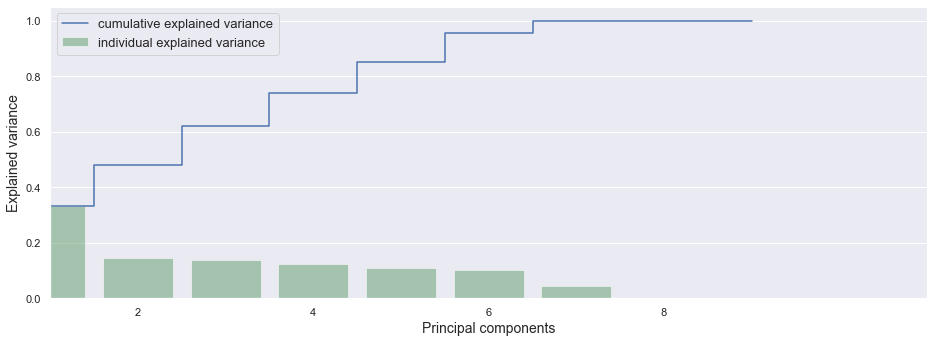

In [56]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

-----
#### Creating customer categories

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

In [57]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.218


At first, I look at the number of customers in each cluster:

In [58]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

,1,0,7,9,8,4,10,6,5,3,2
number of clients,1510,891,528,422,395,308,154,68,56,1,1


** a / _Report via the PCA_ **

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [59]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

C:\Users\rkkir\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


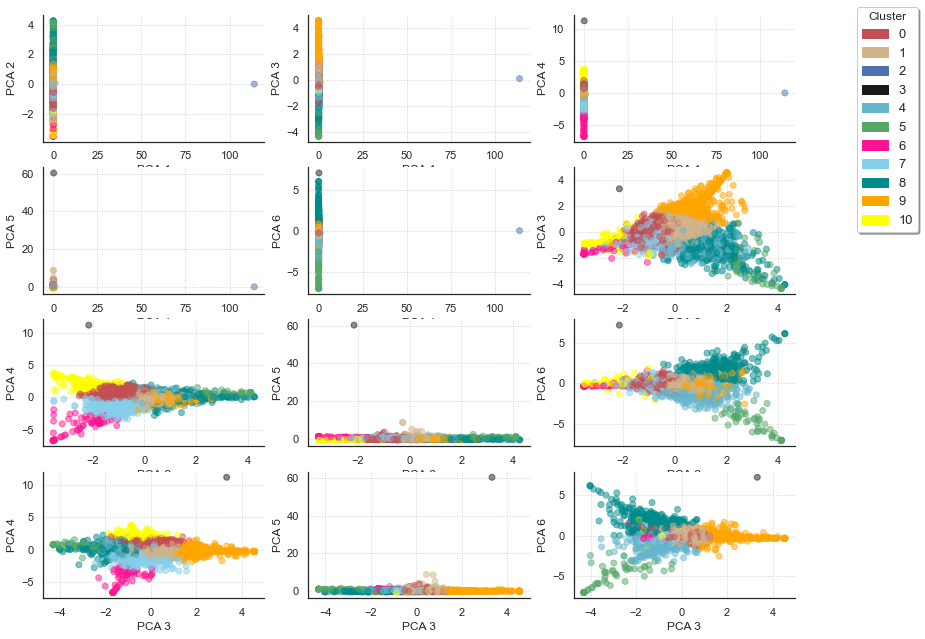

In [60]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                   9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

** b/ _Score of the silhouette intra-cluster_ **

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

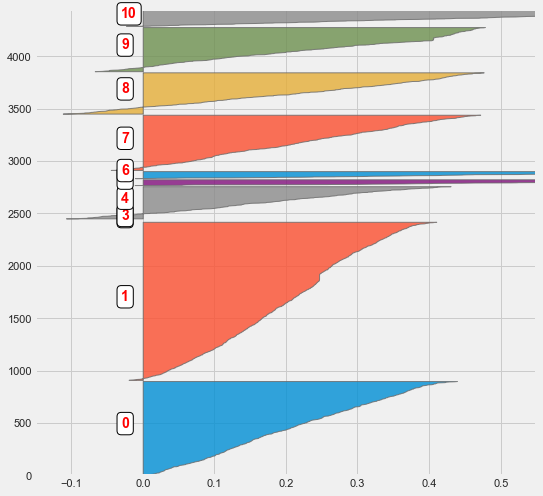

In [61]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silhouette scores 
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, 
                           clusters_clients)

** c/ _Customers morphotype_**

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [62]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [63]:
transaction_data.columns

Index(['UserId', 'TransactionId', 'TransactionTime', 'ItemCode',
       'ItemDescription', 'NumberOfItemsPurchased', 'CostPerItem', 'Country',
       'TotalPrice', 'categ_product', 'categ_0', 'categ_1', 'categ_2',
       'categ_3', 'categ_4'],
      dtype='object')

In [64]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('UserId', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 4334


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [65]:
merged_df.sort_index(0)

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
cluster,,,,,,,,,,,,,
0.0,5.202020,1.049383e+03,2.868440e+03,1.731262e+03,1.153109e+04,7.838420,33.266007,5.377193,2.311423,16.953139,74.236813,228.244669,891
1.0,5.076159,1.255957e+03,3.638483e+03,2.197845e+03,1.118741e+04,6.486835,12.734005,6.795151,2.659138,21.728837,88.692053,236.192715,1510
2.0,1.000000,4.071085e+07,4.071085e+07,4.071085e+07,4.071085e+07,0.000000,0.000000,0.000000,0.000000,0.000000,373.000000,373.000000,1
3.0,1415.000000,1.740000e+00,2.195069e+05,5.004522e+03,7.081399e+06,9.810593,19.093221,5.133715,2.852037,22.343018,0.000000,373.000000,1
4.0,3.775974,8.434811e+02,1.774937e+03,1.225120e+03,5.044341e+03,6.180068,13.877659,10.542422,22.430346,15.097353,97.042208,227.655844,308
5.0,3.964286,6.524389e+02,1.293907e+03,9.129737e+02,5.600346e+03,2.439519,3.425331,3.213731,72.549893,7.428342,121.428571,223.696429,56
6.0,1.970588,1.027116e+03,1.602571e+03,1.285231e+03,2.533521e+03,69.176270,5.991777,2.056054,0.179056,3.805223,137.955882,192.117647,68
7.0,3.416667,1.069863e+03,2.008364e+03,1.476886e+03,5.357223e+03,25.711056,15.906079,4.844421,2.085374,13.544437,85.443182,197.876894,528
8.0,2.718987,8.337848e+02,1.591362e+03,1.152057e+03,3.306025e+03,6.033187,11.574694,34.564539,5.747513,14.254441,105.273418,206.518987,395


** d / Customers morphology garphical representation **

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

In [66]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This allows to have a global view of the content of each cluster:

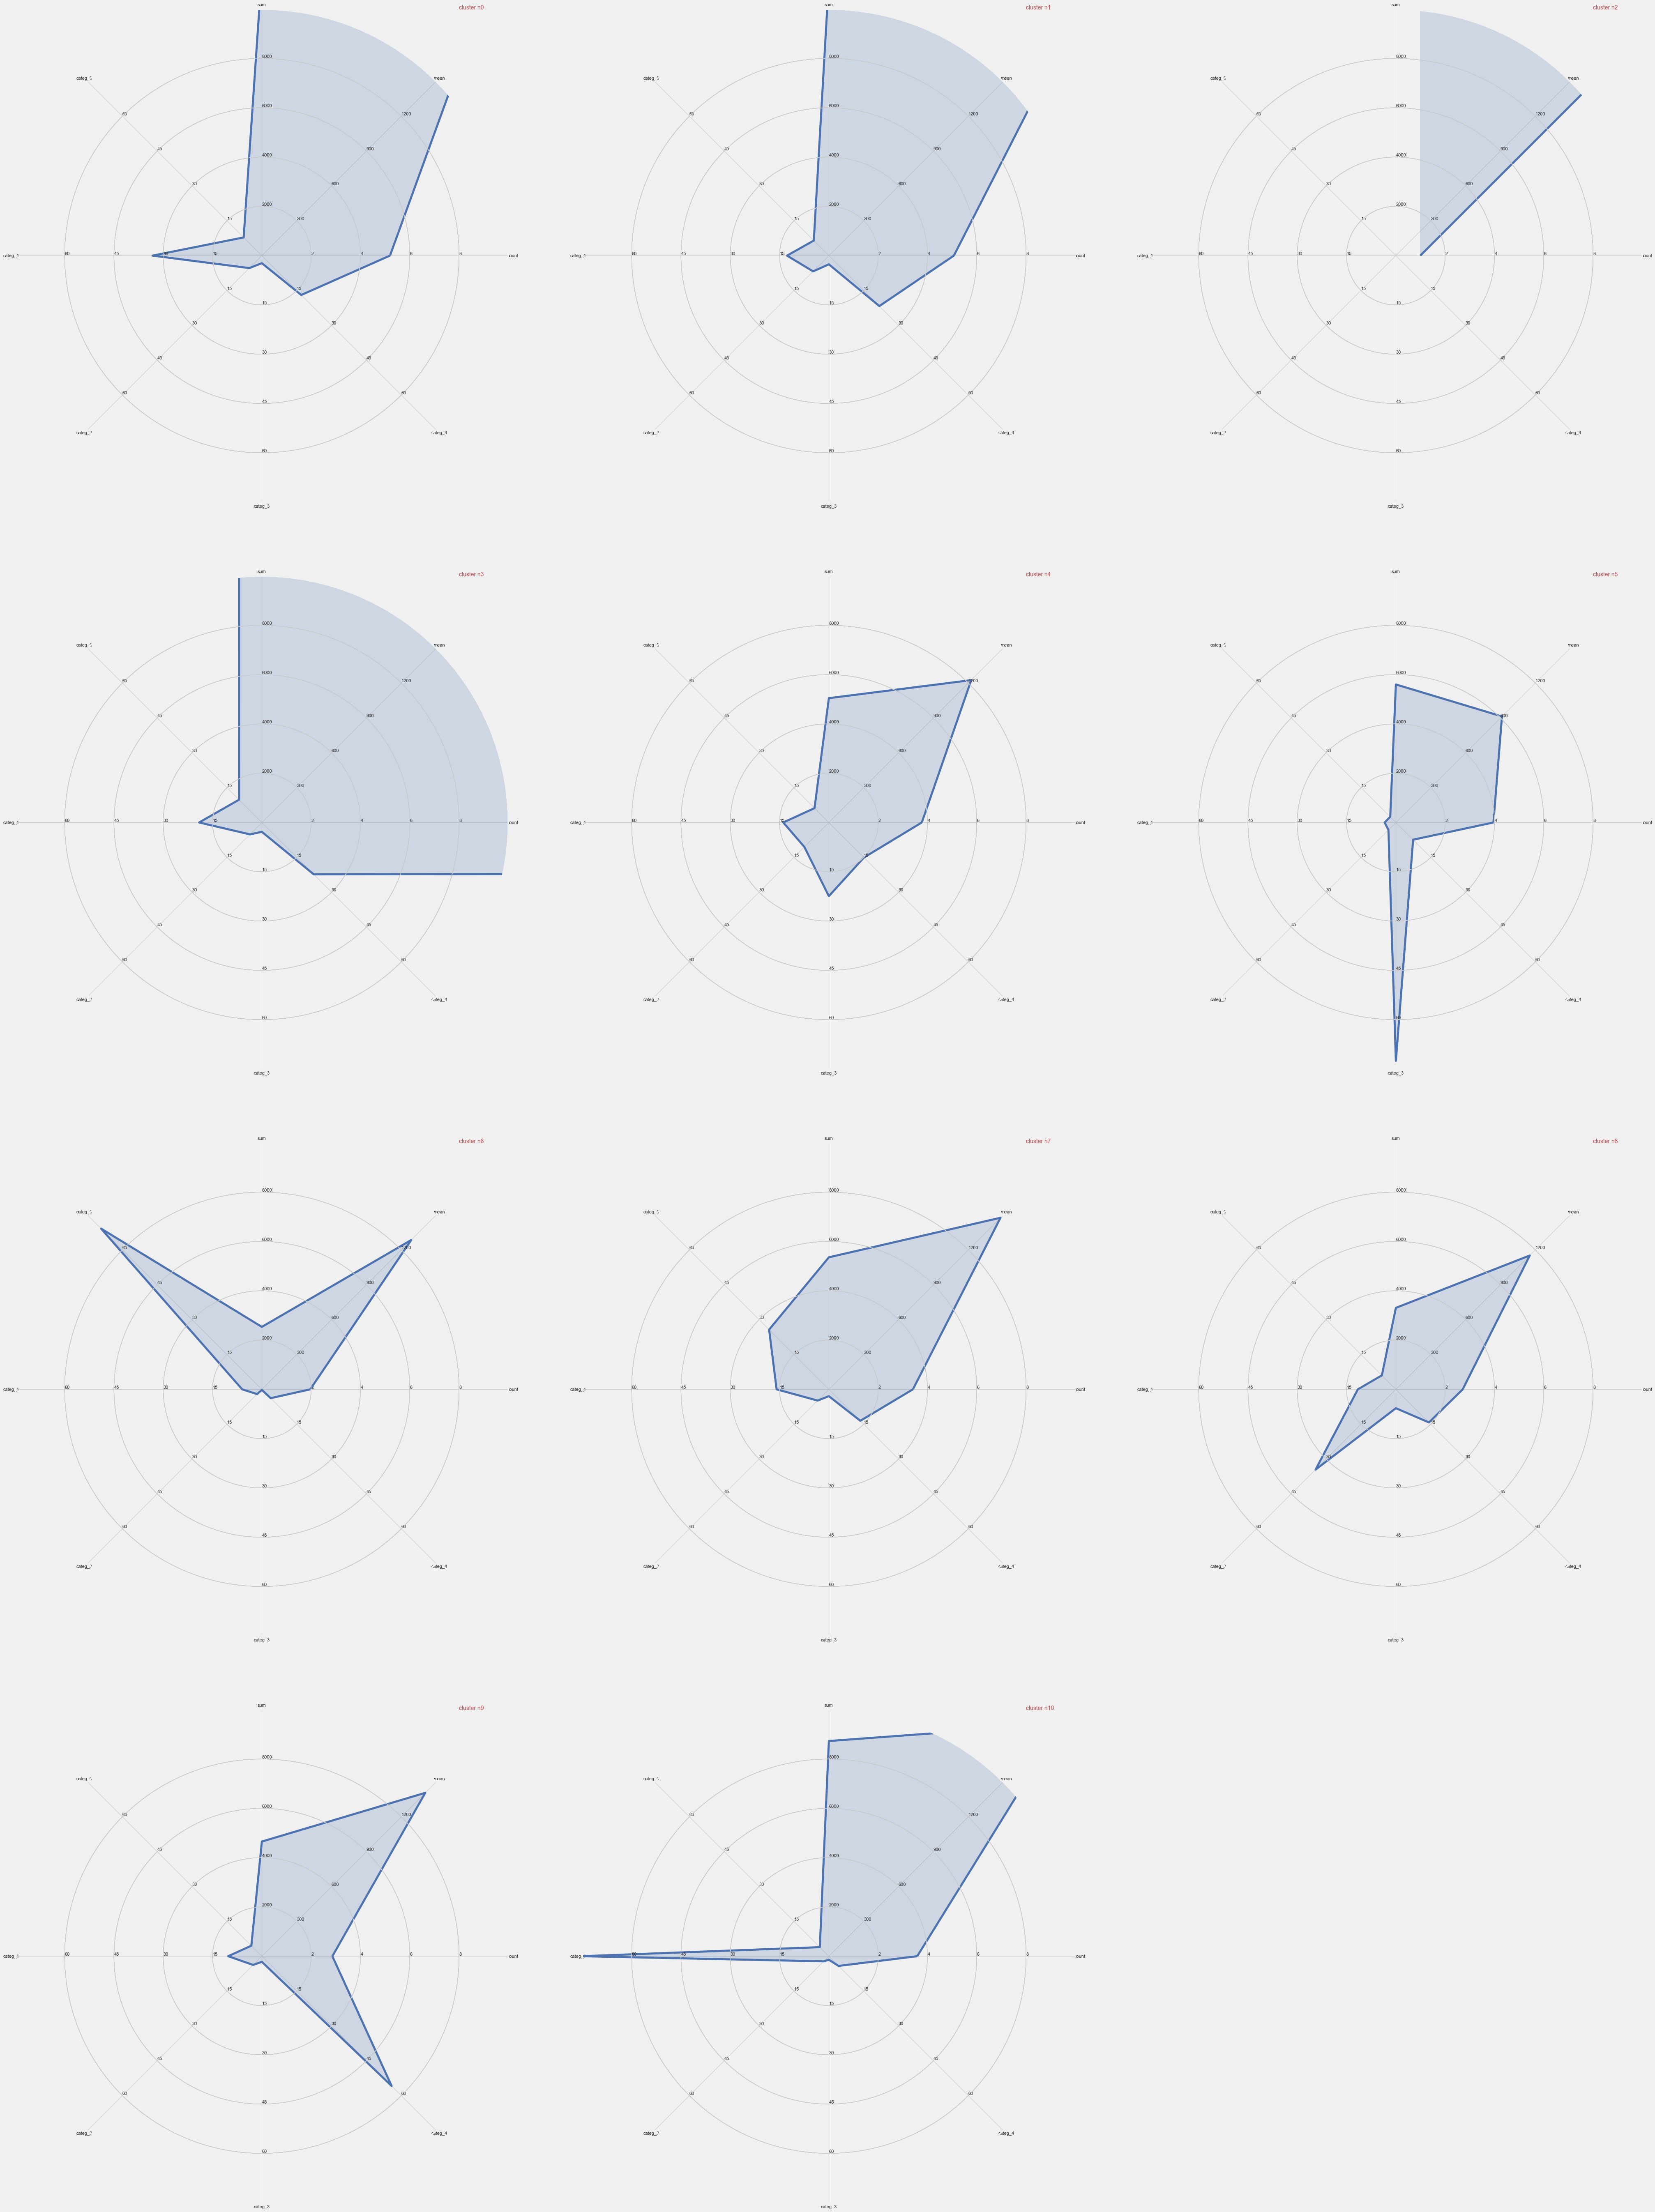

In [67]:
fig = plt.figure(figsize=(50,50))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])  
    #print (data)
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=5.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster n{}'.format(index[ind]), color = 'r')
    ind += 1 

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean **), the total sum spent by the clients (** sum **) or the total number of visits made (** count **).

____

## Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers: 

In [68]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [69]:
selected_customers.head()

,UserId,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,-1,1415,1.74,219506.88,5004.522466,7081399.29,9.810593,19.093221,5.133715,2.852037,22.343018,0,373,3
1,259266,1,320608.80,320608.80,320608.800000,320608.80,0.000000,0.000000,0.000000,0.000000,0.000000,325,325,1
2,259287,6,933.84,5369.10,2488.030000,14928.18,12.903381,26.275809,5.655077,0.766872,32.975889,2,317,0
3,259308,4,959.04,3712.32,1870.380000,7481.52,45.972476,0.000000,9.565971,0.000000,0.000000,75,358,6
4,259329,1,7285.92,7285.92,7285.920000,7285.92,3.330259,8.280354,11.456206,1.981356,18.130312,18,18,1


In [70]:
submission_file=selected_customers[["UserId","cluster"]]
submission_file.to_csv("customer_segementaion.csv")

In [71]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, I split the dataset in train and test sets:

In [72]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the `Class_Fit` class and then call` grid_search()`. When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [73]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

Once this instance is created, I adjust the classifier to the training data:

In [74]:
svc.grid_fit(X = X_train, Y = Y_train)

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to co

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

then I can test the quality of the prediction with respect to the test data:

In [75]:
svc.grid_predict(X_test, Y_test)

Precision: 41.87 % 


Note that for every run precision value may change

___
#### Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [76]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

Confusion matrix, without normalization


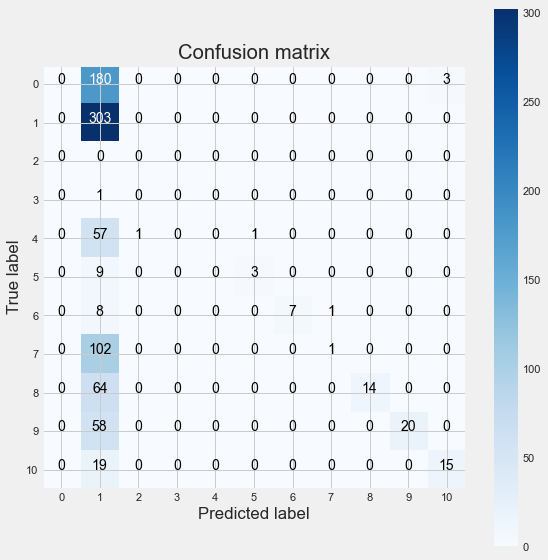

In [77]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')


----------------
#### Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [78]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Revised approach

### Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [79]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
(lr.grid_predict(X_test, Y_test))

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logis

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed t

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' i

Precision: 62.05 % 


C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Then, I plot the learning curve to have a feeling of the quality of the model:

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


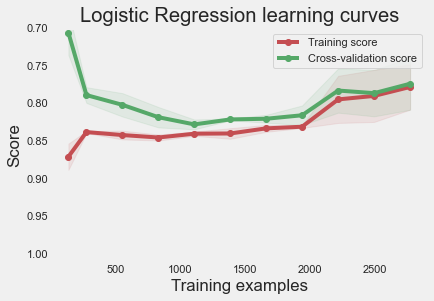

In [80]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### k-Nearest Neighbors

In [81]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Precision: 70.82 % 


C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


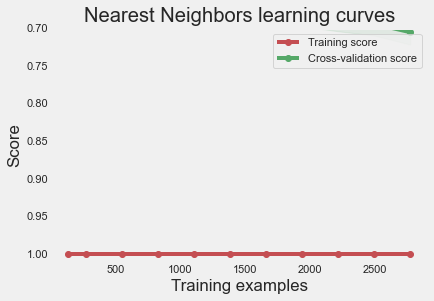

In [82]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Decision Tree


In [83]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Precision: 91.00 % 


C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


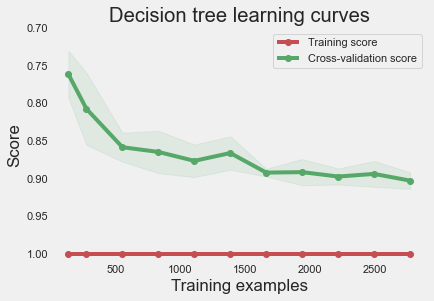

In [84]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Random Forest


In [85]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Precision: 95.50 % 


C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


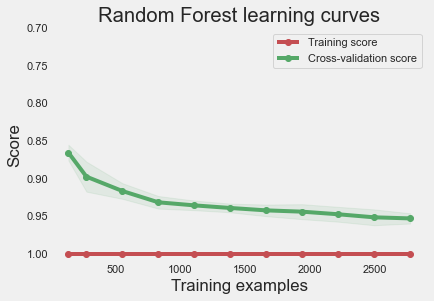

In [86]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost Classifier

In [87]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Precision: 54.90 % 


C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


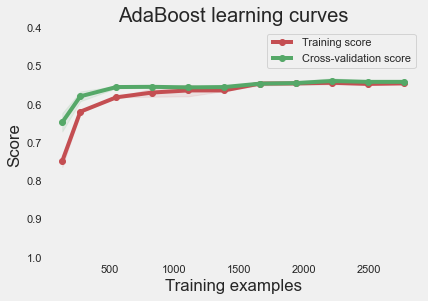

In [88]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

###  Gradient Boosting Classifier


In [89]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Precision: 95.85 % 


C:\Users\rkkir\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


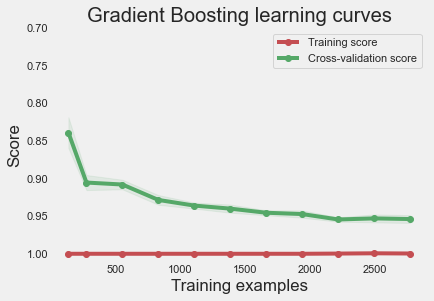

In [90]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

------
## Best approach
### Let's vote !

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the `VotingClassifier` method of the `sklearn` package. As a first step, I adjust the parameters of the various classifiers using the *best* parameters previously found:

In [91]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

In [92]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

and train it:

In [93]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [94]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 94.69 % 


Note that when defining the `votingC` classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *k-Nearest Neighbors* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

___
## Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 8 yrs. In this section, I test the model  the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [95]:
basket_price.InvoiceDate.describe()

count                             19876
unique                            19144
top       2018-07-22 11:06:59.999998464
freq                                  4
first               2018-02-12 04:26:00
last                2019-02-20 08:50:00
Name: InvoiceDate, dtype: object

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set:

In [96]:
basket_price = set_test.copy(deep = True)

In [114]:
basket_price.InvoiceDate.describe()

count                                84
unique                               78
top                 2028-02-18 11:48:00
freq                                  3
first     2028-02-18 05:13:00.000001280
last      2028-02-18 14:36:00.000018688
Name: InvoiceDate, dtype: object

In [97]:
transactions_per_user=basket_price.groupby(by=['UserId'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['UserId'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['UserId'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('UserId', ascending = True)[:5]

,UserId,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,-1,65,65.04,56061.12,14599.017692,948936.15,5.848386,13.894143,3.337290,2.390535,17.713268
1,259287,5,2951.52,2951.52,2951.520000,14757.60,3.293218,14.502358,2.780940,9.013661,40.734266
2,263907,5,1722.06,1722.06,1722.060000,8610.30,4.933626,17.330407,10.759207,0.000000,26.431135
3,265587,5,2473.50,2473.50,2473.500000,12367.50,3.434809,10.217101,0.000000,0.000000,28.890237
4,266301,5,4286.82,4286.82,4286.820000,21434.10,20.816829,49.698378,0.000000,0.000000,9.990622


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [98]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols]
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [99]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [100]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained earlier

In [101]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 31.82 % 
______________________________ 
Logostic Regression
Precision: 57.58 % 
______________________________ 
k-Nearest Neighbors
Precision: 65.15 % 
______________________________ 
Decision Tree
Precision: 89.39 % 
______________________________ 
Random Forest
Precision: 92.42 % 
______________________________ 
Gradient Boosting
Precision: 92.42 % 


Finally, as anticipated in revised approach, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix *Random Forest*, *Gradient Boosting* and *k-Nearest Neighbors* predictions because this leads to a slight improvement in predictions:

In [102]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 96.97 % 
